In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
import warnings
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
warnings.filterwarnings('ignore')
import time


2023-08-27 17:04:18.909445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 17:04:20.135352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-27 17:04:28.901860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 17:04:29.016909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 17:04:29.017192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:

    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-08-24 19:28:55.493782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-24 19:28:55.494007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-24 19:28:55.494137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
batch_size = 32
SIZE=64
ip_channel=3
def load_face_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = load_img(image_path, color_mode='rgb', target_size=(SIZE,SIZE))
        image = img_to_array(image) / 255.0-0.005
        images.append(image)
    return np.array(images)

folder_path = '/home/lagrangian/FACE GAN/Face(128*128)/without_mask'
training_images = load_face_images(folder_path)

In [5]:
len(training_images)

10000

In [6]:
training_images.shape

(10000, 64, 64, 3)

In [7]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential(name="GENERATOR")
    model.add(layers.Dense(SIZE*SIZE*ip_channel, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((SIZE,SIZE,ip_channel)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(64,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())

    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    # model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [8]:
generator = Generator()

In [9]:
generator.summary()

Model: "GENERATOR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12288)             1228800   
                                                                 
 reshape (Reshape)           (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       524288    
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      10

In [10]:
def Discriminato():
    model = tf.keras.models.Sequential(name="DISCRIMINATOR")
    model.add(tf.keras.layers.Input((SIZE,SIZE, ip_channel)))
    model.add(tf.keras.layers.Conv2D(64,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model
  

In [11]:
# Define the loss functions for the generator and discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
# Create the generator and discriminator models
generator = Generator()
discriminator= Discriminato()

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
@tf.function
def train_step(images):
    gen_loss_lst,disc_loss_lst=list(),list()
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        generated_images = tf.image.resize(generated_images,[SIZE,SIZE])

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gen_loss_lst.append(gen_loss)
        disc_loss_lst.append(disc_loss)
        # print("Gen loss: ",gen_loss)
        # print("Tyep of  d loss",type(disc_loss))
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss_lst,disc_loss_lst
# Training loop
EPOCHS = 500
BATCH_SIZE = 32
loss_g,loss_d=list(),list()
for epoch in range(EPOCHS):
    for batch in range(len(training_images) // BATCH_SIZE):
        images = training_images[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]
        g_loss,d_loss=train_step(images)
        loss_g.append(g_loss)
        loss_d.append(d_loss)
    print("At epoch:----",epoch)
    print("Generator Loss: {} Discriminator Loss: {}".format((g_loss),(d_loss)))
# plot_history(g_loss,  d_loss)

2023-08-24 19:33:37.409003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-24 19:33:37.553345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-24 19:33:39.933020: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-08-24 19:33:40.564977: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.65GiB with freed_by_c

At epoch:---- 0
Generator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=3.912804>] Discriminator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=0.050954048>]
At epoch:---- 1
Generator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=5.916583>] Discriminator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=0.005827783>]
At epoch:---- 2
Generator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=6.3556824>] Discriminator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=0.007903239>]
At epoch:---- 3
Generator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=5.9790883>] Discriminator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=0.00528891>]
At epoch:---- 4
Generator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=8.832043>] Discriminator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=0.2662132>]
At epoch:---- 5
Generator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=5.452632>] Discriminator Loss: [<tf.Tensor: shape=(), dtype=float32, numpy=0.023850871>]
At epoch:--

KeyboardInterrupt: 

In [ ]:

def convert_to_numpy(tensor):
    lst=[]
    for i in tensor:
        for j in i:
            lst.append(j.numpy())
    return lst

In [ ]:
loss_value_g=convert_to_numpy(loss_g)
loss_value_d=convert_to_numpy(loss_d)

In [ ]:
len(loss_value_d)

6240

In [ ]:
loss_g[1]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.31495947>]

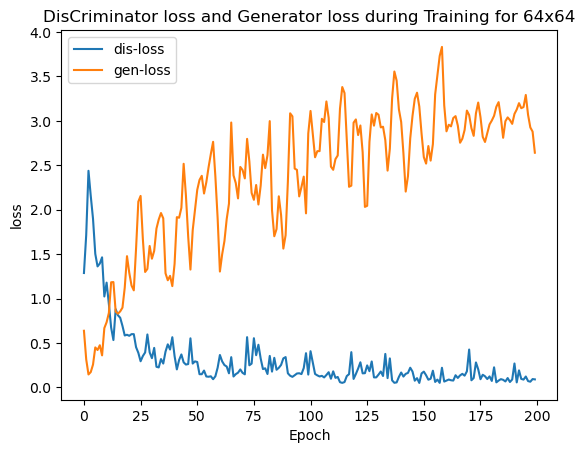

In [ ]:
# plt.subplot(5, 5, 1)
import matplotlib.pyplot as plt
plt.plot(loss_value_d[:200], label='dis-loss')
plt.plot(loss_value_g[:200], label='gen-loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('DisCriminator loss and Generator loss during Training for 64x64')
plt.legend()
plt.show()
plt.close()

In [ ]:
# Generate fake images
num_examples_to_generate = 100
random_noise = tf.random.normal([num_examples_to_generate, 100])

generated_images = generator(random_noise, training=False)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

for i in range(num_examples_to_generate):
    generated_array = tf.keras.backend.get_value(generated_images[i])
    generated_image_ = image.array_to_img(generated_array)
    image.save_img('/home/lagrangian/FACE GAN/Face(128*128)/GEN/epochgenerated_image.5._{}.png'.format(i), generated_image_)

In [ ]:
generated_images.shape

TensorShape([100, 64, 64, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


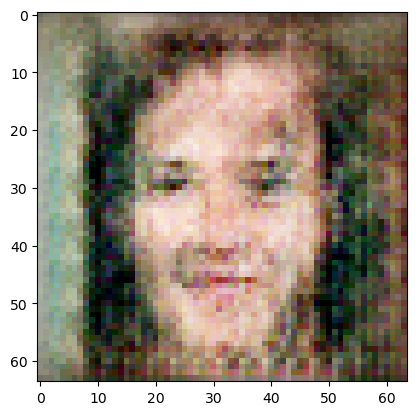

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(generated_images.numpy()[90])

In [ ]:
print(generated_images[1])
generated_images.shape

tf.Tensor(
[[[ 2.33803540e-02  2.44000852e-02  2.00484730e-02]
  [-6.94580823e-02 -7.65084522e-03  7.43850321e-02]
  [ 1.70001201e-02  1.11611597e-01  1.48090422e-01]
  ...
  [ 1.95149740e-03  1.55403286e-01  3.64155769e-02]
  [ 6.19153529e-02 -1.51962921e-01  7.81470463e-02]
  [-4.85481396e-02 -1.31237581e-01  1.56284273e-01]]

 [[ 7.91855529e-02  4.63464893e-02  2.98434701e-02]
  [-1.48504809e-01  2.27737337e-01  1.15861267e-01]
  [ 3.05229306e-01 -5.20667396e-02 -2.25950390e-01]
  ...
  [-9.84685794e-02  6.89941287e-01 -1.09209521e-02]
  [ 5.56354880e-01 -2.30319351e-01 -3.02438200e-01]
  [-6.78373724e-02  3.79030302e-04 -1.92504913e-01]]

 [[ 2.01189145e-02 -1.56160995e-01 -1.07311964e-01]
  [ 1.07957624e-01 -1.19644448e-01 -8.43310542e-03]
  [ 1.79496527e-01 -3.12283665e-01 -4.47498977e-01]
  ...
  [-7.14618526e-03 -6.10342264e-01  1.32698536e-01]
  [-1.97549343e-01 -5.44259012e-01 -4.85313177e-01]
  [ 2.76548415e-01 -6.01644702e-02  2.43190005e-01]]

 ...

 [[ 4.57302071e-02  1.0

TensorShape([20, 64, 64, 3])

In [ ]:
# Save generated images
for i in range(num_examples_to_generate):
    tf.keras.preprocessing.image.save_img('generated_image_{}.png'.format(i), generated_images[i])

In [ ]:
def plot_generated_images(square = 5, epochs = 0):
    
    
  plt.figure(figsize = (4,4))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

### -----------------high resolution------------------------------

In [ ]:
# import numpy as np
# from PIL import Image
# from glob import glob
# from tensorflow import keras
# import tensorflow as tf

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')
# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [ ]:
# class ImageGen:
#     def __init__(self,img_path,low_size=(64,64),high_size=(128,128),rescalling=1./255,val_split=None):
#         self.rescalling = rescalling
#         self.low_size = low_size
#         self.high_size = high_size
#         x = glob(img_path+"/*.png")
#         self.train_files = None
#         self.val_files = None
#         self.train_files = glob(img_path+"/*.png")
#         print("Training files:",len(self.train_files))
           
#     def imageLoader(self,batch_size,subset="train"):
       
#         if subset=="train":
#             files = self.train_files
#         else:
#             files = self.val_files
           
#         data_len = len(files)
#         inf = True
#         while inf:

#             batch_start = 0
#             batch_end = batch_size

#             while batch_start<data_len:
#                 limit = min(batch_end,data_len)
#                 X = np.array([np.array(Image.open(fname).resize(self.low_size)) for fname in files[batch_start:limit]],dtype=np.float16)
#                 X = X*self.rescalling
#                 Y = np.array([np.array(Image.open(fname).resize(self.high_size)) for fname in files[batch_start:limit]],dtype=np.float16)
#                 Y = Y*self.rescalling

#                 yield(X,Y)

#                 batch_start = batch_end
#                 batch_end += batch_size
               
#             if subset=="val":
#                 inf = False
               
#     def getTestData(self):
       
#         X = np.array([np.array(Image.open(fname).resize(self.low_size)) for fname in self.val_files])
#         X=X*self.rescalling
#         Y = np.array([np.array(Image.open(fname).resize(self.high_size)) for fname in self.val_files])
#         Y=Y*self.rescalling
       
#         return X,Y


In [ ]:
# img_path = "//home/lagrangian/FACE GAN/Face(128*128)/GEN"
# train_ds = ImageGen(img_path=img_path)

Training files: 100


In [ ]:
# import os
# root_logdir=os.path.join(os.curdir,"my_logs_highResolution")

In [ ]:
# def get_run_logdir():
#     import time 
#     run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir,run_id)

In [ ]:
# run_logdir=get_run_logdir()

In [ ]:
# import tensorboard
# tensorboard_cb=keras.callbacks.TensorBoard(run_logdir)

In [ ]:
# imgs = train_ds.imageLoader(8)

In [ ]:
# for i in imgs:
#     imgslow,imgshigh = i
#     break

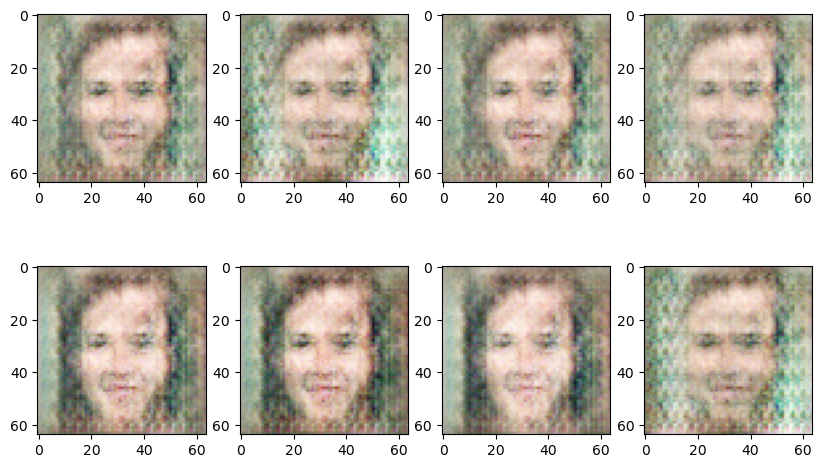

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,6))
# for i in range(8):
#     ax = plt.subplot(2,4,i+1)
#     plt.imshow((imgslow[i]*255).astype('uint8'))

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv2D, UpSampling2D,BatchNormalization

# model = Sequential()

# # Add a convolutional layer
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(None, None, 3)))
# model.add(BatchNormalization())
# # Add additional convolutional layers
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())

# # Add upsampling layers
# model.add(UpSampling2D(size=(2, 2)))
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same'))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

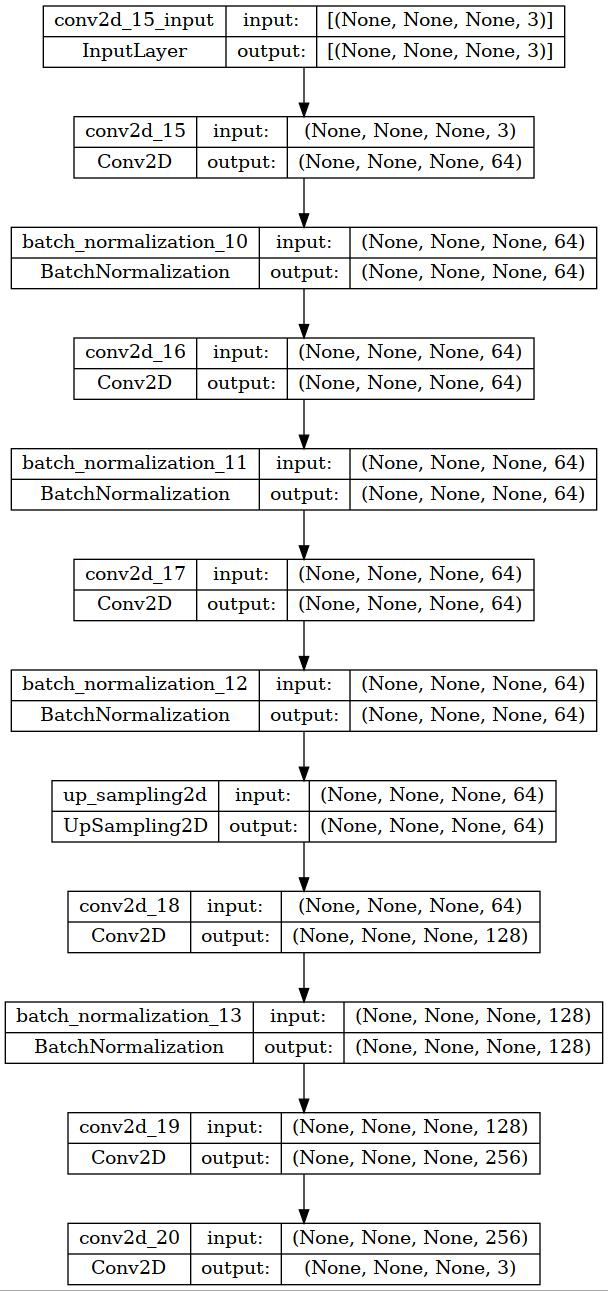

In [ ]:
# plot_model(model,"CNN_for_up.jpg",show_shapes=True)

In [ ]:
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 batch_normalization_10 (Bat  (None, None, None, 64)   256       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 batch_normalization_11 (Bat  (None, None, None, 64)   256       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 batch_normalization_12 (Bat  (None, None, None, 64)   2

In [ ]:
# uncomment when new train is happning

# history = model.fit(train_ds.imageLoader(8),
#                     steps_per_epoch=len(train_ds.train_files)/8,
#                     use_multiprocessing=True,
#                     verbose=1,
#                     epochs=50,
#                     callbacks=[tensorboard_cb])

In [ ]:
# model.save("highRes.h5")

In [ ]:
# #load model
# from tensorflow.keras.models import load_model

# model=load_model("highRes.h5")

In [ ]:
# import cv2
# import os
# from tensorflow.keras.utils import load_img
# from tensorflow.keras.utils import array_to_img,img_to_array

# def generated_hr_images(path):
#     for filename in os.listdir(path):
#         test_image_path = cv2.imread(os.path.join(path,filename))
#         target_size_low_res = (256,256)  # Desired low-resolution size
#         test_image = load_img(test_image_path, target_size=target_size_low_res)
#         test_image_array =img_to_array(test_image)
#         test_image_array = test_image_array / 255.0
#         test_image_input = np.expand_dims(test_image_array, axis=0)
#         predicted_image_array = model.predict(test_image_input)

#         predicted_image_path = '/home/lagrangian/Project_Image/64x64/HR/predicted_high_resolution_image256.jpg'
#         predicted_image = array_to_img(predicted_image_array[0])
#         for i in len(path):
#             predicted_image.save('/home/lagrangian/Project_Image/64X64/HR/HR_image.5._{}.png'.format(i), generated_image_)


In [ ]:
# from tensorflow.keras.utils import load_img
# from tensorflow.keras.utils import array_to_img,img_to_array
# s=128
# test_image_path = '/home/lagrangian/Desktop/seed0742.png'
# target_size_low_res = (s,s) 

# test_image = load_img(test_image_path, target_size=target_size_low_res)
# test_image_array =img_to_array(test_image)
# test_image_array = test_image_array / 255.0

# test_image_input = np.expand_dims(test_image_array, axis=0)

# predicted_image_array = model.predict(test_image_input)

# predicted_image_path = '/home/lagrangian/Desktop/original(128).png'
# predicted_image = array_to_img(predicted_image_array[0])
# predicted_image.save(predicted_image_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/lagrangian/Desktop/seed0742.png'

In [ ]:
# import numpy as np

# def calculate_psnr(img1, img2, max_value=255):
#     mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
#     print(mse)
#     if mse == 0:
#         return 100
#     return 20 * np.log10(max_value / (np.sqrt(mse)))



In [ ]:

# im1 = '/home/lagrangian/DEEP_FASHION/Face(128*128)/without_mask/seed0000.png'
# im2 = '/home/lagrangian/DEEP_FASHION/Face(128*128)/without_mask/seed0001.png'


# img= Image.open(im1)
# np_img = np.array(img)

# img2=Image.open(im2)
# np_img2= np.array(img2)

In [ ]:
# calculate_psnr(np_img,np_img2)

2770.7273


13.704865661531095

In [ ]:
# from PIL import Image
# count = 1
# for img_path in glob('/home/lagrangian/DEEP_FASHION/Face(128*128)/Demo/*.png'):
#     img = Image.open(img_path)
#     img = img.resize((256,256))
#     name = img_path.split("/")[-1]
#     img.save("/home/lagrangian/DEEP_FASHION/face256*256/"+name)
#     count+=1